In [1]:
import numpy as np
import os
import nltk
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.keras as keras
import numpy as np
import pickle


print tf.__version__

Couldn't import dot_parser, loading of dot files will not be possible.


1.3.0


In [2]:
#from tensorflow.contrib.keras.api.keras.preprocessing import sequence
from tensorflow.contrib.keras.api.keras.layers import Input, Embedding, GRU, Dense #, Activation
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.python.keras.layers import Bidirectional, TimeDistributed


In [3]:
SENTENCE_LENGTH_MAX = 80
EMBEDDING_DIM=50

In [9]:
# scraped data file
data = np.load('file2.npy')
data = pd.DataFrame(data,columns=['year', 'date', 'time', 'data', 'site', 'site2', 'date2', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Change','Change2_tmr']) 
print data.head()

   year       date   time                                               data  \
0  2016  oct_9.txt  06:23  Table Tennis: Feng Tianwei upset by Japanese t...   
1  2016  oct_9.txt  06:00  Football: Immobile brings Italy back from the ...   
2  2016  oct_9.txt  04:39  Football: Napoli striker Milik out for â€˜mont...   
3  2016  oct_9.txt  04:23  Thousands of armed Yemeni protesters call for ...   
4  2016  oct_9.txt  04:05  Football: Wales drop World Cup points in Georg...   

                 site                               site2     date2  \
0  http://str.sg/4xhn  [http://str.sg/4xhn, PHOTO:, ITTF]  [10, 09]   
1  http://str.sg/4xhW   [http://str.sg/4xhW, PHOTO:, EPA]  [10, 09]   
2  http://str.sg/4xeY   [http://str.sg/4xeY, PHOTO:, EPA]  [10, 09]   
3  http://str.sg/4xef   [http://str.sg/4xef, PHOTO:, AFP]  [10, 09]   
4  http://str.sg/4xeN   [http://str.sg/4xeN, PHOTO:, AFP]  [10, 09]   

         Date      Open      High       Low     Close Adj Close  Volume Change  
0  2016-10-

In [10]:
sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
import string
printable = set(string.printable)
def remove_nonprintable(s):
    if s is None:
        return None
    return filter(lambda x: x in printable, s)
from nltk.tokenize import TreebankWordTokenizer
data['data_clean'] = data['data'].apply(remove_nonprintable) 
def tokenizer(s):
    if s is None:
        return None
    return TreebankWordTokenizer().tokenize(s)
data['data_clean_tok'] = data['data_clean'].apply(tokenizer)
data = data[~data['data_clean'].isin([None,])] # remove empty data
print data.head()

   year       date   time                                               data  \
0  2016  oct_9.txt  06:23  Table Tennis: Feng Tianwei upset by Japanese t...   
1  2016  oct_9.txt  06:00  Football: Immobile brings Italy back from the ...   
2  2016  oct_9.txt  04:39  Football: Napoli striker Milik out for â€˜mont...   
3  2016  oct_9.txt  04:23  Thousands of armed Yemeni protesters call for ...   
4  2016  oct_9.txt  04:05  Football: Wales drop World Cup points in Georg...   

                 site                               site2     date2  \
0  http://str.sg/4xhn  [http://str.sg/4xhn, PHOTO:, ITTF]  [10, 09]   
1  http://str.sg/4xhW   [http://str.sg/4xhW, PHOTO:, EPA]  [10, 09]   
2  http://str.sg/4xeY   [http://str.sg/4xeY, PHOTO:, EPA]  [10, 09]   
3  http://str.sg/4xef   [http://str.sg/4xef, PHOTO:, AFP]  [10, 09]   
4  http://str.sg/4xeN   [http://str.sg/4xeN, PHOTO:, AFP]  [10, 09]   

         Date      Open      High       Low     Close Adj Close  Volume  \
0  2016-10-09  2.

In [11]:
import sys
sys.path.append('/media/leexa/97ba6a6b-3f4d-4528-84ca-50200ba4594f/Dropbox/dl_dev_course/deep-learning-workshop/notebooks/5-RNN/glove-python')
import glove
glove_dir = '../week5/data/RNN/'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)
if not os.path.isfile( glove_100k_50d_path ):
    raise RuntimeError("You need to download GloVE Embeddings "+
                       ": Use the downloader in 5-Text-Corpus-and-Embeddings.ipynb")
else:
    print("GloVE available locally")
word_embedding = glove.Glove.load_stanford( glove_100k_50d_path )
word_embedding.word_vectors.shape

GloVE available locally


(100000, 50)

In [13]:
def word_idx_rnn(list):
    if list is None:
        return None
    return map(lambda word : 2+word_embedding.dictionary.get(word.lower(),-1),list) #0 for mask 1 for unknown

word_embedding_rnn = np.vstack([ 
        np.zeros( (1, EMBEDDING_DIM,), dtype='float32'),   # This is the 'zero' value (used as a mask in Keras)
        np.zeros( (1, EMBEDDING_DIM,), dtype='float32'),   # This is for 'UNK'  (word == 1)
        word_embedding.word_vectors,
    ])
word_embedding_rnn.shape

data['wordVec'] =  map(word_idx_rnn, data['data_clean_tok'].iloc[:])
data = data[data['wordVec'].apply(len) <= SENTENCE_LENGTH_MAX].reset_index(drop=1) #remove too long sentences

  
from tensorflow.contrib.keras.python.keras.utils.np_utils import to_categorical
tokens_input = Input(shape=(SENTENCE_LENGTH_MAX,), dtype='int32', name="input")

In [15]:
data.head(1)

,year,date,time,data,site,site2,date2,Date,Open,High,Low,Close,Adj Close,Volume,Change,data_clean,data_clean_tok,wordVec
0,2016,oct_9.txt,06:23,Table Tennis: Feng Tianwei upset by Japanese t...,http://str.sg/4xhn,"[http://str.sg/4xhn, PHOTO:, ITTF]","[10, 09]",2016-10-09,2.930000,2.930000,2.920000,2.930000,2.8396,141900,0,Table Tennis: Feng Tianwei upset by Japanese t...,"[Table, Tennis, :, Feng, Tianwei, upset, by, J...","[1803, 2142, 47, 13494, 1, 3593, 23, 625, 7188..."


In [11]:
# function to remove 769 and other death words
def remove769(x):
    result = []
    for i in x:
        if i not in [2359,5378,338,5251,433,769]:
            result += [i,] 
    return result
data['wordVec2'] = data['wordVec'].apply(remove769)
# pad sequences to length 32
data['wordVec2'] = map(lambda x :x + (SENTENCE_LENGTH_MAX - len(x)) * [0,],data['wordVec2'])
data['died'] = 0
data= data.set_value(ids,'died',1)
print 'number of death articles'
print np.mean(data.died)

number of death articles
0.0591584941474


In [12]:
#view data
data.iloc[26][[u'data_clean', u'data_clean_tok', u'wordVec', u'wordVec2',u'died']]

data_clean        UPDATE:82 dead, 534 injured in Saudi-led airst...
data_clean_tok    [UPDATE:82, dead, ,, 534, injured, in, Saudi-l...
wordVec           [1, 769, 3, 44573, 1004, 8, 1, 15641, 15, 5404...
wordVec2          [1, 3, 44573, 1004, 8, 1, 15641, 15, 5404, 124...
died                                                              1
Name: 26, dtype: object

In [13]:
# view data
data.iloc[27][[u'data_clean', u'data_clean_tok', u'wordVec', u'wordVec2',u'died']]

data_clean        Erdogan takes spin in first-ever road tunnel l...
data_clean_tok    [Erdogan, takes, spin, in, first-ever, road, t...
wordVec           [9347, 1146, 6027, 8, 30087, 588, 4518, 6409, ...
wordVec2          [9347, 1146, 6027, 8, 30087, 588, 4518, 6409, ...
died                                                              0
Name: 27, dtype: object

In [14]:
tokens_input = Input(shape=(SENTENCE_LENGTH_MAX,), dtype='int32', name="input")
embedded_sequences = Embedding(word_embedding_rnn.shape[0],
                                EMBEDDING_DIM,
                                weights=[ word_embedding_rnn ],
                                input_length=SENTENCE_LENGTH_MAX,
                                trainable=False, 
                                mask_zero=True,
                                name="SentencesEmbedded") (tokens_input)
aggregate_vectors = embedded_sequences # concat...
TAG_SET_SIZE = 1
BATCH_SIZE = 32
RNN_HIDDEN_SIZE = 65
masked = keras.layers.Masking(mask_value=0.0,name='masked') (aggregate_vectors)
rnn_outputs = Bidirectional( GRU(RNN_HIDDEN_SIZE, return_sequences=False),  merge_mode='concat' )(masked)
rnn_outputs2 = keras.layers.Dropout(0.5,name='drop')(rnn_outputs)
is_ner_outputs = Dense(1, activation='sigmoid',name='out')(rnn_outputs2)
model = Model(inputs=[tokens_input], outputs=[is_ner_outputs])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 80)                0         
_________________________________________________________________
SentencesEmbedded (Embedding (None, 80, 50)            5000100   
_________________________________________________________________
masked (Masking)             (None, 80, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 130)               45240     
_________________________________________________________________
drop (Dropout)               (None, 130)               0         
_________________________________________________________________
out (Dense)                  (None, 1)                 131       
Total params: 5,045,471
Trainable params: 45,371
Non-trainable params: 5,000,100
_____________________________________________________________

In [15]:
import keras.backend as K
#https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def MCC(y_true, y_pred): #balanced metric
    y_pred_pos = K.greater_equal(y_pred, 0.5)
    y_pred_pos = K.cast(y_pred_pos,K.tf.float32)
    y_pred_neg = 1 - y_pred_pos
    
    y_pos = K.greater_equal(y_true, 0.5)
    y_pos = K.cast(y_pos,K.tf.float32)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())
model.compile(loss='binary_crossentropy', optimizer="adam" , metrics=['accuracy',MCC])

Using TensorFlow backend.


In [16]:
X = np.stack(map(np.array,data.wordVec2))
y = np.array(data.died.astype(np.int32))
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4, random_state = 5)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state = 5)

In [17]:
class_weight = {0 : 1.,
                1: 15.7,} # class ratios are 15.7 : 1, helps objective function to be balanced
epochs = 10 #optimal is 10-15
history  = model.fit(x=X_train,y=y_train,
                     epochs = epochs,verbose = 2,
                     batch_size = 32,
                     validation_data = (X_val,y_val),
                     class_weight = class_weight)

Train on 3793 samples, validate on 1264 samples
Epoch 1/10
13s - loss: 1.1664 - acc: 0.6678 - MCC: 0.1304 - val_loss: 0.5684 - val_acc: 0.7136 - val_MCC: 0.2248
Epoch 2/10
14s - loss: 0.9572 - acc: 0.7437 - MCC: 0.2435 - val_loss: 0.4461 - val_acc: 0.7824 - val_MCC: 0.2222
Epoch 3/10
12s - loss: 0.8267 - acc: 0.7835 - MCC: 0.2752 - val_loss: 0.3895 - val_acc: 0.8093 - val_MCC: 0.2385
Epoch 4/10
12s - loss: 0.7822 - acc: 0.7975 - MCC: 0.3155 - val_loss: 0.4782 - val_acc: 0.7722 - val_MCC: 0.2812
Epoch 5/10
11s - loss: 0.7117 - acc: 0.8197 - MCC: 0.3287 - val_loss: 0.3683 - val_acc: 0.8196 - val_MCC: 0.2536
Epoch 6/10
11s - loss: 0.6430 - acc: 0.8292 - MCC: 0.3717 - val_loss: 0.4339 - val_acc: 0.7911 - val_MCC: 0.2804
Epoch 7/10
11s - loss: 0.5620 - acc: 0.8516 - MCC: 0.4075 - val_loss: 0.3210 - val_acc: 0.8560 - val_MCC: 0.3244
Epoch 8/10
11s - loss: 0.5316 - acc: 0.8576 - MCC: 0.4078 - val_loss: 0.3640 - val_acc: 0.8275 - val_MCC: 0.2889
Epoch 9/10
11s - loss: 0.4270 - acc: 0.8800 - MC

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),history.history['MCC'])
plt.plot(range(epochs),history.history['val_MCC'])
plt.show()

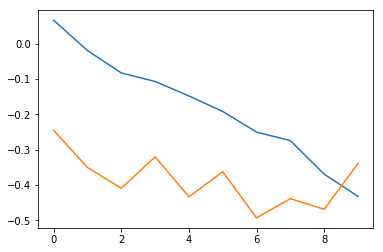

In [19]:
plt.plot(range(epochs),map(np.log10,history.history['loss']))
plt.plot(range(epochs),map(np.log10,history.history['val_loss']))
plt.show()

In [20]:
# get ensemble predictions
y_pred_test = np.zeros(shape=(len(y_test),1))
y_pred_val = np.zeros(shape=(len(y_val),1))
for i in range(0,5):
    model.fit(x=X_train,y=y_train,
                         epochs = 1,verbose = 2,
                         batch_size = 32,
                         validation_data = (X_val,y_val),
                         class_weight = class_weight)
    temp = model.predict(X_test)
    y_pred_test = y_pred_test + temp/5
    temp = model.predict(X_val)
    y_pred_val = y_pred_val + temp/5

Train on 3793 samples, validate on 1264 samples
Epoch 1/1
11s - loss: 0.2863 - acc: 0.9259 - MCC: 0.5813 - val_loss: 0.2824 - val_acc: 0.9051 - val_MCC: 0.3072
Train on 3793 samples, validate on 1264 samples
Epoch 1/1
11s - loss: 0.2182 - acc: 0.9436 - MCC: 0.6283 - val_loss: 0.2590 - val_acc: 0.9122 - val_MCC: 0.2503
Train on 3793 samples, validate on 1264 samples
Epoch 1/1
11s - loss: 0.1987 - acc: 0.9499 - MCC: 0.6482 - val_loss: 0.3341 - val_acc: 0.8766 - val_MCC: 0.2922
Train on 3793 samples, validate on 1264 samples
Epoch 1/1
11s - loss: 0.1745 - acc: 0.9578 - MCC: 0.6366 - val_loss: 0.2759 - val_acc: 0.9074 - val_MCC: 0.2597
Train on 3793 samples, validate on 1264 samples
Epoch 1/1
11s - loss: 0.1060 - acc: 0.9760 - MCC: 0.7735 - val_loss: 0.3099 - val_acc: 0.9153 - val_MCC: 0.3487


In [21]:
def MCC_numpy(y_true, y_pred): #balanced metric
    assert y_true.shape == y_pred.shape
    y_pred_pos = 1*(y_pred > 0.5)
    y_pred_neg = 1 - y_pred_pos

    y_pos = 1*(y_true > 0.5)
    y_neg = 1 - y_pos

    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)

    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    #print tp , tn , fp ,fn
    numerator = (tp * tn - fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator/denominator

In [22]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef = MCC_numpy
print matthews_corrcoef(y_val,y_pred_val[:,0])
print matthews_corrcoef(y_val,temp[:,0])
print matthews_corrcoef(y_test,y_pred_test[:,0])
# values are higher because MCC is not supposed to be used in batches but rather the whole dataset

0.364097172124
0.384929828616
0.396558891214


In [28]:
# find the wrong answers
wrong = X_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong_y = y_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong_pred = y_pred_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong.shape

(92, 80)

In [29]:
for i,j,k in zip( wrong,wrong_y,wrong_pred)[0:]:
    id_wrong = np.argmax(np.sum(np.array([data['wordVec2']]) == list(i),(0,2)))
    # print text, label, prediction
    print data.iloc[id_wrong]['data_clean'],j,k,'\n'

Nurse charged with murdering 8 in Canadian old-age homesA Canadian nurse was charged on Tuesday (Oct 25) with using drugs to  killing spree that ran for seven years.  0 [ 0.73458332] 

Man shoots Philadelphia police officer, cites Islam as motive - officialA gunman claiming to have pledged allegiance to Islamic State in Iraq and Syria (ISIS) militants shoots and seriously wounds a Philadelphia police officer as he sits in his patrol car in an ambush-style attack. 0 [ 0.76135127] 

Driver who died in AYE accident had starred in TV commercialsThe 37-year-old man who died in a six-vehicle collision on the Ayer Rajah Expressway on Monday (Dec 19) morning was an actor and event emcee who appeared in several commercials.  1 [ 0.13945401] 

Sony Music's Twitter hacked, fake Britney Spears death tweets sentSony Music Entertainment's Twitter account was hacked on Monday, publishing fake statements that pop music icon Britney Spears had died. 1 [ 0.00107569] 

Four killed in Greek tourist boat c

# CORECT predictions 

In [25]:
# find the correct answers
wrong = X_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong_y = y_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong_pred = y_pred_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong.shape

(1173, 80)

In [26]:
for i,j,k in zip( wrong,wrong_y,wrong_pred)[0::20]:
    id_wrong = np.argmax(np.sum(np.array([data['wordVec2']]) == list(i),(0,2)))
    # print text, label, prediction
    print data.iloc[id_wrong]['data_clean'],j,k,'\n'

Twilight's Kristen Stewart tells Elle UK she's 'really in love with my girlfriend'American actress Kristen Stewart, who played the girlfriend of Robert Pattinson in the Twilight movie series and subsequently in real life, is for the first time speaking publicly of her current love interest - another woman. 0 [ 0.04554121] 

Unsung heroes of Paris attacks honoured at concertSome 12,000 emergency and health workers, security officials and others honoured at a concert on Monday (Dec 21) in Paris.  0 [ 0.05070087] 

Olympics: IOC under fire for 'confusing mess' after letting Russia escape blanket doping banThe International Olympic Committee on Sunday decided against hitting Russia with a blanket ban from the Rio Games over state-run doping, sparking an immediate backlash from groups that had demanded bold action against cheating. 0 [ 0.00377355] 

Football: Spain's Maria Villar withdraws bid for Uefa top jobAngel Maria Villar, the head of Spain's football association, announces he has wit